In [1]:
import pandas as pd 
from utils import * 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from src.files import BLASTJsonFile, InterProScanFile
import re
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
dataset_path = '../data/results/results-2/dataset.csv'
top_hit_predictions_path = '../data/results/results-2/top_hits_predict.csv'
predictions_path = '../data/results/results-2/dataset_predict.csv'

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 

results_df = load_results(dataset_path=dataset_path, top_hit_predictions_path=top_hit_predictions_path, predictions_path=predictions_path, exclude_genome_ids=exclude_genome_ids)

results_df = results_df[results_df.intergenic].copy() # Filter for intergenic sequences. 
results_df = results_df[results_df.index != 'NC_021487.1_1505'].copy() # Drop an outlier which spans an assembly gap and is >1900 amino acids long. 

In [100]:
results_df['has_rbs'] = results_df.query_rbs_motif != 'none'
results_df.value_counts(['model_label', 'has_rbs'])

model_label  has_rbs
spurious     True       233
real         True       201
spurious     False       80
uncertain    True        71
real         False       53
uncertain    False       15
Name: count, dtype: int64

In [3]:
print('Num. intergenic ORFs:', len(results_df))
print('Num. real intergenic ORFs:', results_df.real.sum(), f'({get_percent(results_df.real.sum(), len(results_df))})')
print('Num. uncertain intergenic ORFs:', results_df.uncertain.sum(), f'({get_percent(results_df.uncertain.sum(), len(results_df))})')
print('Num. spurious intergenic ORFs:', results_df.spurious.sum(), f'({get_percent(results_df.spurious.sum(), len(results_df))})')

write_fasta(results_df, '../data/results/results-2/intergenic.faa', add_top_hit=False)

Num. intergenic ORFs: 653
Num. real intergenic ORFs: 254 (38.90%)
Num. uncertain intergenic ORFs: 86 (13.17%)
Num. spurious intergenic ORFs: 313 (47.93%)
write_fasta: Wrote 653 sequences to ../data/results/results-2/intergenic.faa


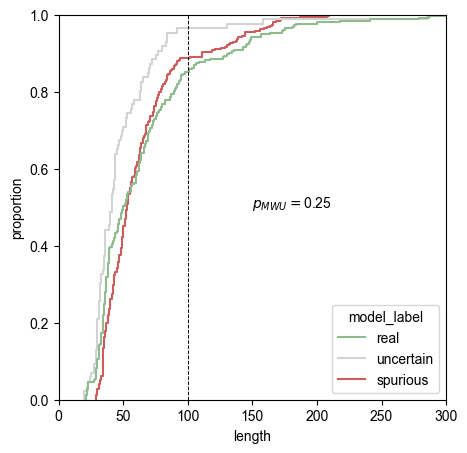

In [62]:
def figure(results_df:pd.DataFrame, ids:list=None):

    figure_df = results_df.loc[ids].copy() if (ids is not None) else results_df.copy()

    fig, ax = plt.subplots(figsize=(5, 5))
    palette = {'real':'darkseagreen', 'uncertain':'lightgray', 'spurious':'indianred'}
    # sns.kdeplot(results_df, hue='model_label', palette=palette, x='length', common_norm=False)
    sns.ecdfplot(figure_df, hue='model_label', palette=palette, x='length')
    ax.set_xlim(xmax=300, xmin=0)
    ax.set_ylabel('proportion')

    p = get_mann_whitney_p_value(results_df[results_df.spurious].length, results_df[results_df.real].length)
    ax.text(0.5, 0.5, '$p_{MWU}=$' + f'{p:.2f}', transform=ax.transAxes)

    ax.axvline(100, ls='--', color='black', lw=0.7)
    plt.show()

figure(results_df)
# print('Max. length:', results_df.length.max()) # Seems crazy that such a long ORF was missed in the reference? Seems to span an assembly gap, has a long run of X's.


In [64]:
# BLASTp against NCBI clustered nr database, with the following parameters:
# Bacteria
# Max. target sequences     10
# Expect threshold      0.005

blast_df = BLASTJsonFile('../data/results/results-2/intergenic_blast.json').to_df()
# It seems to be a good idea to not apply a cutoff of 50, as many of the proteins are very short, and bit score is length-dependent. Opted for a slightly lower cutoff of 40.
blast_df = blast_df[blast_df.bit_score > 40].copy() # Filter for significant BLAST hits. 

blast_df['n_hits'] = blast_df.index.map(blast_df.groupby(blast_df.index).size())
blast_df['hypothetical'] = blast_df.subject_description.str.contains(r'hypothetical|uncharacterized|uncharacterised|unknown', regex=True, case=False)
print(f'Num. hits to hypothetical proteins:', blast_df.hypothetical.sum(), f'({get_percent(blast_df.hypothetical.sum(), len(blast_df))})')
print(f'Removing {((blast_df.percent_identity == 1) & blast_df.hypothetical).sum()} uninformative hits.', end='\n\n')

blast_df = blast_df[~(((blast_df.percent_identity == 1) & blast_df.hypothetical))].copy()
blast_df['model_label'] = blast_df.index.map(results_df.model_label)
blast_df['model_output_1'] = blast_df.index.map(results_df.model_output_1)
blast_df['real'] = blast_df.index.map(results_df.real)
blast_df['spurious'] = blast_df.index.map(results_df.spurious)
blast_df['partial'] = blast_df.subject_description.str.contains('partial') # Make sure to mark things as partial BEFORE applying the map. 
blast_df['subject_description'] = blast_df.subject_description.replace(SUBJECT_DESCRIPTION_MAP)
blast_df['subject_description'] = np.where(blast_df.hypothetical, 'hypothetical protein', blast_df.subject_description)
blast_df['length_ratio'] = blast_df.alignment_length / blast_df.subject_length


# blast_df = blast_df[~blast_df.partial].copy()

print('Num. with BLAST hit:', blast_df.index.nunique())
print('Num. real with BLAST hit:', blast_df[blast_df.real].index.nunique(), f'({get_percent(blast_df[blast_df.real].index.nunique(), results_df.real.sum())})')
print('Num. real with annotated BLAST hit:', blast_df[blast_df.real & ~blast_df.hypothetical].index.nunique(),  f'({get_percent(blast_df[blast_df.real & ~blast_df.hypothetical].index.nunique(), results_df.real.sum())})')
print('Num. spurious with BLAST hit:', blast_df[blast_df.spurious].index.nunique(), f'({get_percent(blast_df[blast_df.spurious].index.nunique(), results_df.spurious.sum())})')
print('Num. spurious with annotated BLAST hit:', blast_df[blast_df.spurious & ~blast_df.hypothetical].index.nunique(), f'({get_percent(blast_df[blast_df.spurious & ~blast_df.hypothetical].index.nunique(), results_df.real.sum())})')

# It is unclear why PGAP misses so many sequences with annotated BLAST hits. Theoretically, PGAP checks every potential ORF

# https://pmc.ncbi.nlm.nih.gov/articles/PMC7779008/#SEC3 

# Spurious or faulty protein sequences in these databases were identified by examination of multiple sequence alignments containing these proteins, similar RefSeq 
# proteins, and GeneMarkS-2 ab initio predictions on other genomes in the same genus or order. A total of 3437 low-quality proteins from otherwise highly trusted 
# reference genomes, that are frameshifted, have start sites inconsistent with most related proteins, or are suspect in other ways (7.4% of all reference proteins) 
# were removed from the reference protein database. Similarly, a total of 195 964 protein fragments, frameshifted proteins or proteins in incorrect frames, were 
# removed from the database of cluster representatives based on manual curation, detection of transposase fragments according to transposase reference sequences, 
# multiple sequence alignments of protein homologs, and analyses of proteins with partial HMM hits. Furthermore, the weight of 2.5 million proteins representative 
# of clusters from rare species was adjusted down to minimize their impact on annotation, and PGAP was modified to trust GeneMarkS-2+ more than homology evidence 
# from rare protein clusters on the presence or absence of a protein-coding feature. Since October 2019, candidate models supported by the alignments of proteins 
# with low combined weight are rejected unless they are also supported by GeneMarkS-2+ ab initio model or an HMM hit. 


Num. hits to hypothetical proteins: 1281 (66.20%)
Removing 317 uninformative hits.

Num. with BLAST hit: 288
Num. real with BLAST hit: 174 (68.50%)
Num. real with annotated BLAST hit: 83 (32.68%)
Num. spurious with BLAST hit: 87 (27.80%)
Num. spurious with annotated BLAST hit: 35 (13.78%)


figure: Num. ORFs with only hypothetical hits: 125 (43.40%)


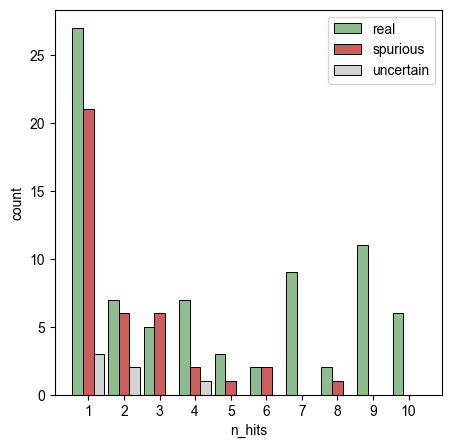

In [101]:
#

def figure(results_df, blast_df):

    n_with_blast_hits = blast_df.index.nunique()
    # Only want to consider sequences that *only* align to hypothetical proteins. 
    blast_df['all_hits_hypothetical'] = blast_df.groupby(blast_df.index).apply(lambda df : np.all(df.hypothetical), include_groups=False) 
    blast_df = blast_df[blast_df.all_hits_hypothetical].copy()

    # Probably want to filter for cases where the subject makes up at least __% of the length of the aligned subject.
    blast_df = blast_df[blast_df['length_ratio'] > 0.6].copy()

    figure_df = pd.DataFrame(index=pd.Series(blast_df.index.unique(), name='id'))
    figure_df['model_label'] = results_df.model_label
    figure_df['n_hits'] = blast_df.groupby(blast_df.index).size()
    print(f'figure: Num. ORFs with only hypothetical hits:', len(figure_df), f'({get_percent(len(figure_df), n_with_blast_hits)})')

    offsets = {'real':-0.3, 'spurious':0, 'uncertain':0.3}
    palette = {'real':'darkseagreen', 'uncertain':'lightgray', 'spurious':'indianred'}

    fig, ax = plt.subplots(figsize=(5, 5))

    n_hits = np.arange(1, 11)
    for model_label, df in figure_df.groupby('model_label'):
        heights = np.array([(df.n_hits == n).sum() for n in n_hits])
        ax.bar(n_hits + offsets[model_label], heights, color=palette[model_label], width=0.3, edgecolor='black', lw=0.7, label=model_label)

    ax.set_xticks(n_hits, labels=n_hits)
    ax.set_ylabel('count')
    ax.set_xlabel('n_hits')
    ax.legend()
    plt.show()


figure(results_df, blast_df)

Num. aligned to annotated proteins: 135
Num. real aligned to annotated proteins: 83 (61.48%)
Num. spurious aligned to annotated proteins: 35 (25.93%)
Num. uncertain aligned to annotated proteins: 17 (12.59%)


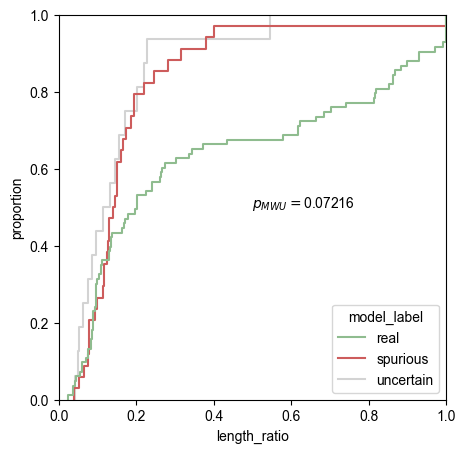

In [104]:
n_annotated = blast_df[~blast_df.hypothetical].index.nunique()
print('Num. aligned to annotated proteins:', n_annotated)
for model_label, df in blast_df.groupby('model_label'):
    print(f'Num. {model_label} aligned to annotated proteins:', df[~df.hypothetical].index.nunique(), f'({get_percent(df[~df.hypothetical].index.nunique(), n_annotated)})')

# ids_with_annotated_blast_hit = blast_df[~blast_df.hypothetical].index.unique()

# Notably, seems as though the length of the sequence has very little effect on whether or not the fragment is real or spurious.
def figure(blast_df:pd.DataFrame, annotated_only:bool=True, x='query_length', x_max:float=300, x_min:float=30):

    blast_df = blast_df[(~blast_df.hypothetical) & ~blast_df.partial].copy() if annotated_only else blast_df[~blast_df.partial].copy()
    blast_df = blast_df.sort_values('subject_length', ascending=False)

    figure_df = blast_df[~blast_df.index.duplicated(keep='first')].copy()

    fig, ax = plt.subplots(figsize=(5, 5))
    palette = {'real':'darkseagreen', 'uncertain':'lightgray', 'spurious':'indianred'}

    sns.ecdfplot(figure_df, hue='model_label', palette=palette, x=x)

    ax.set_xlim(xmax=x_max, xmin=x_min)
    ax.set_ylabel('proportion')

    p = get_mann_whitney_p_value(figure_df[figure_df.model_label == 'real'][x], figure_df[figure_df.model_label == 'spurious'][x], n_permutations=None)
    ax.text(0.5, 0.5, '$p_{MWU}=$' + f'{p:.5f}', transform=ax.transAxes)

    # ax.axvline(100, ls='--', color='black', lw=0.7)
    plt.show()

# figure(blast_df, x='query_length')
figure(blast_df, x='length_ratio', x_max=1, x_min=0)

In [ ]:
# Curious to see what the intergenic sequences are close to in embedding space. 
! cat '../data/results/results-2/intergenic.faa' '../data/dataset/swissprot_bacteria.faa' > '../data/results/results-2/intergenic_swissprot.faa'

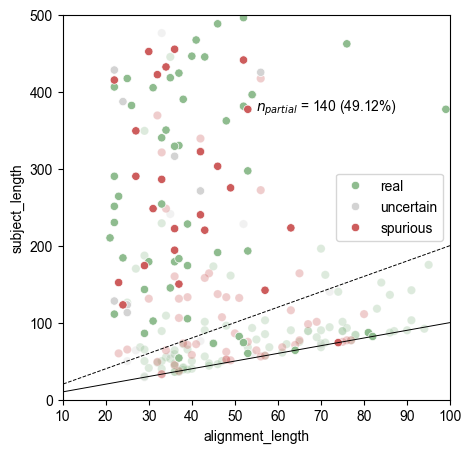

In [55]:
# TODO: Not sure if the selected axis boundaries are at all misleading.

# Some of the proteins with BLAST hits might be fragments. Would be useful to check which ones are substantially shorter than the BLAST alignment. 
fig, ax = plt.subplots(figsize=(5, 5))
figure_df = blast_df[~blast_df.partial].copy() # Remove alignments to partial sequences.
# figure_df = figure_df[~figure_df.hypothetical].copy()
figure_df = figure_df.sort_values('subject_length', ascending=False)
figure_df = figure_df[~figure_df.index.duplicated(keep='first')]
figure_df = figure_df.sort_values('spurious')
# figure_df = figure_df[~figure_df.hypothetical].copy() # Remove alignments to hypothetical proteins. 
# ax.scatter(figure_df.query_length, figure_df.subject_length, color=figure_df.model_label.map(palette), alpha=figure_df.percent_identity, s=10)
sns.scatterplot(figure_df[figure_df.hypothetical], x='alignment_length', y='subject_length', hue='model_label', palette=palette, alpha=0.3, legend=False)
sns.scatterplot(figure_df[~figure_df.hypothetical], x='alignment_length', y='subject_length', hue='model_label', palette=palette, alpha=1)
sns.lineplot(x=np.arange(500), y=np.arange(500),  color='black', lw=0.7)
ax.set_ylim(ymax=500, ymin=0)
ax.set_xlim(xmin=10, xmax=100)

partial_threshold = 0.5
sns.lineplot(x=partial_threshold * np.arange(500), y=np.arange(500), ls='--', color='black', lw=0.7)
n = (figure_df.alignment_length < (partial_threshold * figure_df.subject_length)).sum()
ax.text(0.5, 0.7, get_text('partial', n, len(figure_df)), transform=ax.transAxes)

plt.show()

# The spurious sequences which appear close in length to their BLAST hits are:
# NZ_QXIU01000242.1_4 (111 amino acids) aligned to ATP-binding protein (111 amino acids)
# NZ_CP065383.1_988	(133 amino acids) aligned to transposase (150 amino acids)

In [11]:
# def get_ids_with_shared_blast_hits(id_:str, blast_df:pd.DataFrame=blast_df):
    
#     blast_df = blast_df[blast_df.subject_id.isin(blast_df[blast_df.index == id_].subject_id.values)]
#     return blast_df.index.unique()

# shared_blast_hit_ids = {id_:get_ids_with_shared_blast_hits(id_) for id_ in tqdm(results_df.index.values, desc='Searching for shared BLAST hits.')}
# shared_blast_hit_ids = {id_:id_list for id_, id_list in shared_blast_hit_ids.items() if (len(id_list) > 1)}

# Based on sequences with the matching BLAST hits, it seems as though there are some cases where sequences that are not exactly adjacent might
# be part of the same fragment gene (e.g. NZ_JAALLS010000005.1_6 and NZ_JAALLS010000005.1_9, NZ_AP035449.1_1416 and 'NZ_AP035449.1_1424)

In [12]:
# print('Num. ORFs that share a BLAST hit with another ORF:', len(shared_blast_hit_ids))
# # print('Num. ORFs which are adjacent to another ORF:', len(adjacent_ids))
# print('Num. ORFs that are adjacent and share a BLAST hit with another ORF:', len(np.intersect1d(list(shared_blast_hit_ids.keys()), list(adjacent_ids))))

In [14]:
# blast_df[blast_df.subject_description.str.contains('YcxB')] # Interesting, seems as though they are both aligned. I wonder how common this is. 

max_separation_length = 1000

def is_same_contig(id_1:str, id_2:str):
    if id_1 == id_2:
        return False
    pattern = r'([A-Z]{2}_[0-9A-Z]+\.\d+)_(\d+)'
    match_1, match_2 = re.search(pattern, id_1), re.search(pattern, id_2)
    contig_id_1, contig_id_2 = match_1.group(1), match_2.group(1)
    return (contig_id_1 == contig_id_2) 

def get_info(id_, suffix:str='1', fields=['query_start', 'query_stop', 'query_strand', 'query_id', 'query_length']):
    info = results_df[fields].loc[id_].to_dict()
    info = {key.replace('query_', '') + f'_{suffix}':value for key, value in info.items()}
    return info

# Probably easiest to deal with this by building a DataFrame. 
df = list()
for id_1 in results_df.index:
    nearby_ids = [id_2 for id_2 in results_df.index if is_same_contig(id_1, id_2)]
    for id_2 in nearby_ids:
        row = get_info(id_1, suffix='1')
        row.update(get_info(id_2, suffix='2'))
        df.append(row)
df = pd.DataFrame(df)

get_overlap_length = lambda df : np.min([df.stop_1.values, df.stop_2.values], axis=0) - np.max([df.start_1.values, df.start_2.values], axis=0) + 1
get_separation_length = lambda df :  np.max([df.start_1.values, df.start_2.values], axis=0) - np.min([df.stop_1.values, df.stop_2.values], axis=0)
df['overlap'] = ~((df.stop_1 < df.start_2) | (df.start_1 > df.stop_2))
df['overlap_length'] = np.where(df.overlap, get_overlap_length(df), 0)
df['separation_length'] = np.where(~df.overlap, get_separation_length(df), 0)
df = df[df.separation_length < max_separation_length].copy()

descriptions = {id_:(','.join(blast_df[blast_df.index == id_].subject_description.unique()) if id_ in blast_df.index else 'none') for id_ in results_df.index}
df['description_1'] = df.id_1.replace(descriptions)
df['description_2'] = df.id_2.replace(descriptions)
df['model_label_1'] = df.id_1.map(results_df.model_label)
df['model_label_2'] = df.id_2.map(results_df.model_label)
df['model_output_1_1'] = df.id_1.map(results_df.model_output_1)
df['model_output_1_2'] = df.id_2.map(results_df.model_output_1)
df['same_strand'] = df.strand_1 == df.strand_2
df['phase'] = (np.abs(df.start_1 - df.start_2) % 3)
df['in_frame'] = ((np.abs(df.start_1 - df.start_2) % 3) == 0) & df.same_strand
# # Not many of the adjacent proteins have significant BLAST hits. 
# adjacent_descriptions = {id_1:[blast_df.loc[id_2].subject_description for id_2 in id_list if (id_2 in blast_df.index)] for id_1, id_list in adjacent_ids.items() if (id_1 in blast_df.index)}
# adjacent_model_labels = {id_1:[results_df.loc[id_2].model_label for id_2 in id_list] for id_1, id_list in adjacent_ids.items()}

print(f'Num. ORFs within {max_separation_length} bp from another intergenic ORF:', df.id_1.nunique(), f'({get_percent(df.id_1.nunique(), len(results_df))})')
print(f'Num. ORFs in-frame with their neighbor ORF:', df[df.in_frame].id_1.nunique(), f'({get_percent(df[df.in_frame].id_1.nunique(), len(results_df))})')

Num. ORFs within 1000 bp from another intergenic ORF: 53 (8.12%)
Num. ORFs in-frame with their neighbor ORF: 12 (1.84%)


In [ ]:
# df['both_real'] = (df.model_label_1 == 'real') & (df.model_label_2 == 'real')
# df['one_real'] = ((df.model_label_1 == 'real') & (df.model_label_2 != 'real')) | ((df.model_label_2 == 'real') & (df.model_label_1 != 'real'))
# df['neither_real'] = (df.model_label_1 != 'real') & (df.model_label_2 != 'real')
# df['category'] = np.select([df.both_real, df.neither_real, df.one_real], ['both_real', 'neither_real', 'one_real'], default='none')

In [102]:
# fig, ax = plt.subplots(figsize=(5, 5))
# sns.kdeplot(df, x='separation_length', hue='same_strand', palette={True:'gray', False:'lightgray'})
# ax.set_xlim(xmin=0, xmax=max_separation_length)
# ax.set_ylabel('density')


In [ ]:
# TODO: Why are transposase so frequently fragmented?

# AbrB/MazE/SpoVT could be involved in sporulation (SpoVT), antitoxin activity, or antibacterial resisistance (AbrB). All of these are transcriptional regulators.  

# The YcxB-like protein family includes the B. subtilis YcxB protein, which is a functionally uncharacterized transmembrane protein. Interestingly, one of these is classified as real, and one as spurious.

# Ig-like domains in E. coli and enterobacteria are frequently found in cell surface proteins and fimbrial organelles playing important functions during host cell adhesion and invasion (e.g. intimin/invasin family of outer membrane (OM) adhesins.) https://academic.oup.com/femsre/article/37/2/204/623411 

# CcmD is a family of small, integral membrane proteins crucial for the maturation of c-type cytochromes. 




In [ ]:
interpro_df = InterProScanFile('../data/results/results-2/intergenic_interpro.tsv').to_df()
interpro_df['model_label'] = interpro_df.index.map(results_df.model_label)
interpro_df['real'] = interpro_df.index.map(results_df.real)
interpro_df['spurious'] = interpro_df.index.map(results_df.spurious)

print('Num. ORFs with InterProScan hits:', interpro_df.index.nunique()) # This includes the slightly bullshitty ones like disorder prediction. 
print('Num. real ORFs with InterProScan hits:', interpro_df[interpro_df.real].index.nunique()) # This includes the slightly bullshitty ones like disorder prediction. 
print('Num. spurious ORFs with InterProScan hits:', interpro_df[interpro_df.spurious].index.nunique(), end='\n\n') # This includes the slightly bullshitty ones like disorder prediction. 

interpro_df = interpro_df.dropna(subset=['interpro_e_value']) # Exclude the MobiDBLite hits and coils and some other stuff. 

print('Num. ORFs with InterProScan hits:', interpro_df.index.nunique())
print('Num. real ORFs with InterProScan hits:', interpro_df[interpro_df.real].index.nunique()) 
print('Num. spurious ORFs with InterProScan hits:', interpro_df[interpro_df.spurious].index.nunique(), end='\n\n')


Num. ORFs with InterProScan hits: 97
Num. real ORFs with InterProScan hits: 51
Num. spurious ORFs with InterProScan hits: 38

Num. ORFs with InterProScan hits: 32
Num. real ORFs with InterProScan hits: 28
Num. spurious ORFs with InterProScan hits: 3

